In [0]:
# Load Packages
import numpy as np
import sklearn.datasets as ds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
# Data Preparation Function
def prepare_data(num=[1,3,5,7,9]):
    ## valid_digits is a vector containing the digits
    ## we wish to classify.
    ## Do not change anything inside of this function
    data = ds.load_digits()
    labels = data['target']
    features = data['data']
    X = features
    Y = labels
    X = X / np.repeat(np.max(X, axis=1), 64).reshape(X.shape[0], -1)
    for i in range(len(Y)):
      Y[i] = 1 if Y[i] in num else 0

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=10)
    Y_train = Y_train.reshape((len(Y_train), 1))
    Y_test = Y_test.reshape((len(Y_test), 1))

    return X_train, Y_train, X_test, Y_test

In [3]:
X_train, Y_train, X_test, Y_test = prepare_data()
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1347, 64) (1347, 1)
(450, 64) (450, 1)


In [0]:
def gau_kernel(x, y, gamma):
    return np.prod(np.exp(-gamma * (x-y) ** 2))

In [0]:
def svm_Kernel(X1,X2,gamma):
  n = X1.shape[0]
  k = X2.shape[0]
  K = np.zeros(n*k).reshape((k,n))
  
  for i in range(k):
    for j in range(n):
      K[i,j] = np.prod(gau_kernel(X1[j,:],X2[i,:],gamma))
      
  return(K)

In [0]:
def svm_predict(X,Y,alpha,kernel,K):
  
  X_train = X['train']
  X_test = X['test']
  Y_train = Y['train']
  Y_test = Y['test']
  
  n = len(Y_train)
  k = len(Y_test)
  
  if kernel == None:
  
    beta = np.zeros(X_train.shape[1])
  
    for i in range(n):
      beta += alpha[i]*Y_train[i]*X_train[i,:]
    
    f_pred = np.sign(np.matmul(X_train,beta))
    acc_train = sum(f_pred==Y_train)/len(Y_train)
  
    f_test = np.sign(np.matmul(X_test,beta))
    acc_test = sum(f_test==Y_test)/len(Y_test)
  
  elif kernel == 'Gaussian':
  
    f_pred = np.zeros(n)
    
    K_train = K['train']
    K_test = K['test']
  
    for i in range(n):
      f_pred[i] = np.sign(sum(alpha*Y_train*K_train[i,:]))
    
    acc_train = sum(f_pred==Y_train)/len(Y_train)
  
    f_test = np.zeros(k)
  
    for i in range(k):
      f_test[i] = np.sign(sum(alpha*Y_train*K_test[i,:]))
    
    acc_test = sum(f_test==Y_test)/len(Y_test)
    
  return(acc_train,acc_test,f_pred,f_test)
    

In [0]:
def svm(X_train,X_test,Y_train,Y_test,kernel=None,lamb=0.01,num_iterations=200,learning_rate=0.1):
  
  gamma = 0.1
  
  n = len(Y_train)
  
  Y_tr = np.asarray([lb[0] for lb in Y_train])
  Y_tr[Y_tr==0] = -1
  Y_t = np.asarray([lb[0] for lb in Y_test])
  Y_t[Y_t==0] = -1
  
  Q = np.zeros(n*n).reshape((n,n))
  
  if kernel == None:
  
    for i in range(n):
      for j in range(n):
        Q[i,j] = Y_tr[i]*Y_tr[j]*np.matmul(X_train[i,:],X_train[j,:])

  elif kernel == 'Gaussian':
  
    K_train = svm_Kernel(X_train,X_train,gamma)
  
    for i in range(n):
      for j in range(n):
        Q[i,j] = Y_tr[i]*Y_tr[j]*K_train[i,j]
  
  X = {'train':X_train,'test':X_test}
  Y = {'train':Y_tr,'test':Y_t}

  if kernel == 'Gaussian':
    K_train = svm_Kernel(X_train,X_train,gamma)
    K_test = svm_Kernel(X_train,X_test,gamma)
    K = {'train':K_train,'test':K_test}
  else: K = None
  
  acc_train = []
  acc_test = []
  alpha = np.random.uniform(0,1/lamb,n)

  for it in range(num_iterations):
  
    for idx in range(n):
      d_alpha = (1-np.matmul(Q[idx,:].transpose(),alpha))/Q[idx,idx]
      alpha[idx] = alpha[idx] + d_alpha*learning_rate
        
      if alpha[idx] <= 0:
        alpha[idx] = 0
      elif alpha[idx] >= 1/lamb:
        alpha[idx] = 1/lamb
      
    if it%(num_iterations/20) == 0:
      acc_tr,acc_t,_,_ = svm_predict(X,Y,alpha,kernel,K)
      acc_train.append(acc_tr)
      acc_test.append(acc_t)
      print('At epoch %d, Training Accuracy: %f, Testing Accuracy: %f' %(it+1,acc_tr,acc_t))
      
  acc_tr,acc_t,Y_train_pre,Y_test_pre = svm_predict(X,Y,alpha,kernel,K)
  acc_train.append(acc_tr)
  acc_test.append(acc_t)
  print('At epoch %d, Training Accuracy: %f, Testing Accuracy: %f' %(num_iterations,acc_tr,acc_t))
      
  return(acc_train,acc_test,Y_train_pre,Y_test_pre)

In [43]:
acc_train,acc_test,Y_train_pre,Y_test_pre = svm(X_train,X_test,Y_train,Y_test,num_iterations=1000)

At epoch 1, Training Accuracy: 0.887899, Testing Accuracy: 0.855556
At epoch 51, Training Accuracy: 0.873794, Testing Accuracy: 0.851111
At epoch 101, Training Accuracy: 0.871566, Testing Accuracy: 0.853333
At epoch 151, Training Accuracy: 0.884929, Testing Accuracy: 0.871111
At epoch 201, Training Accuracy: 0.892353, Testing Accuracy: 0.877778
At epoch 251, Training Accuracy: 0.888641, Testing Accuracy: 0.884444
At epoch 301, Training Accuracy: 0.893838, Testing Accuracy: 0.893333
At epoch 351, Training Accuracy: 0.903489, Testing Accuracy: 0.884444
At epoch 401, Training Accuracy: 0.907201, Testing Accuracy: 0.886667
At epoch 451, Training Accuracy: 0.907944, Testing Accuracy: 0.897778
At epoch 501, Training Accuracy: 0.911656, Testing Accuracy: 0.902222
At epoch 551, Training Accuracy: 0.913140, Testing Accuracy: 0.908889
At epoch 601, Training Accuracy: 0.914625, Testing Accuracy: 0.900000
At epoch 651, Training Accuracy: 0.916110, Testing Accuracy: 0.902222
At epoch 701, Training 

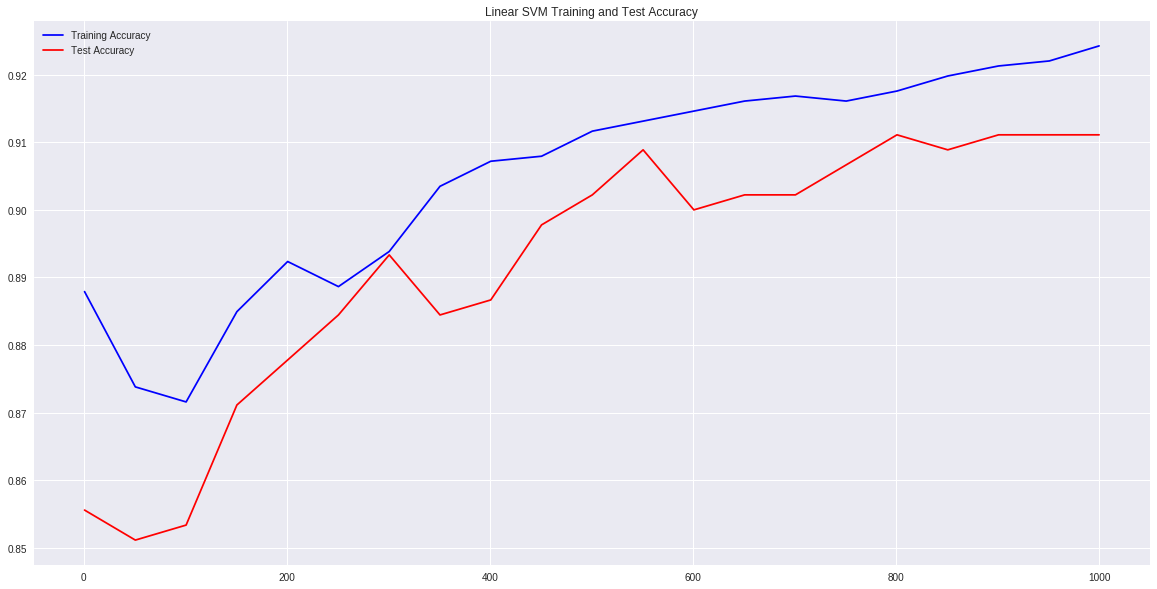

In [50]:
ep = int(1000/(1000/20))
epochs = np.append(np.array(list(range(ep)))*(1000/20)+1,1000)

plt.figure(figsize = (20,10))
plt.plot(epochs,acc_train,'blue',label='Training Accuracy')
plt.plot(epochs,acc_test,'red',label='Test Accuracy')
plt.title('Linear SVM Training and Test Accuracy')
plt.legend()

In [49]:
kernel_acc_train,kernel_acc_test,kernel_Y_train_pre,kernel_Y_test_pre = svm(X_train,X_test,Y_train,Y_test,kernel='Gaussian')

At epoch 1, Training Accuracy: 0.914625, Testing Accuracy: 0.915556
At epoch 11, Training Accuracy: 0.986637, Testing Accuracy: 0.977778
At epoch 21, Training Accuracy: 0.990349, Testing Accuracy: 0.982222
At epoch 31, Training Accuracy: 0.991091, Testing Accuracy: 0.977778
At epoch 41, Training Accuracy: 0.991091, Testing Accuracy: 0.968889
At epoch 51, Training Accuracy: 0.994061, Testing Accuracy: 0.968889
At epoch 61, Training Accuracy: 0.995546, Testing Accuracy: 0.971111
At epoch 71, Training Accuracy: 0.995546, Testing Accuracy: 0.975556
At epoch 81, Training Accuracy: 0.997030, Testing Accuracy: 0.977778
At epoch 91, Training Accuracy: 0.997773, Testing Accuracy: 0.982222
At epoch 101, Training Accuracy: 0.998515, Testing Accuracy: 0.986667
At epoch 111, Training Accuracy: 1.000000, Testing Accuracy: 0.991111
At epoch 121, Training Accuracy: 1.000000, Testing Accuracy: 0.993333
At epoch 131, Training Accuracy: 1.000000, Testing Accuracy: 0.991111
At epoch 141, Training Accuracy

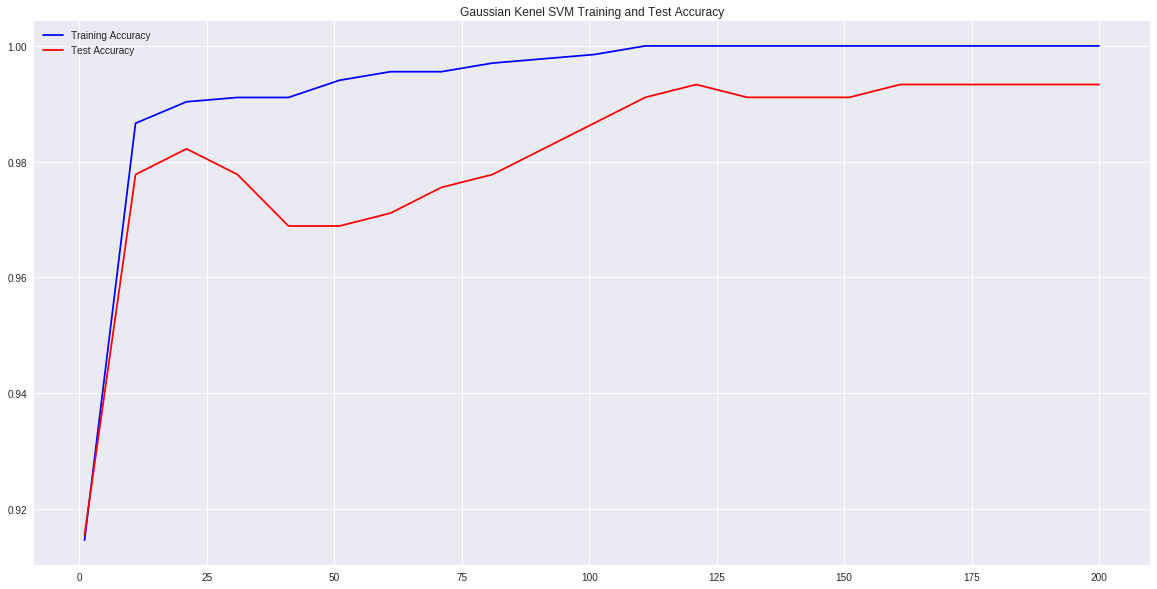

In [52]:
ep = int(200/(200/20))
epochs = np.append(np.array(list(range(ep)))*(200/20)+1,200)

plt.figure(figsize = (20,10))
plt.plot(epochs,kernel_acc_train,'blue',label='Training Accuracy')
plt.plot(epochs,kernel_acc_test,'red',label='Test Accuracy')
plt.title('Gaussian Kenel SVM Training and Test Accuracy')
plt.legend()